# Generative Adversarial Network

- We'll build a GAN on MNIST dataset and generate handwritten digits.
- There are two networks competing against each other in GAN: generator G and discriminator D.
- Generator will generate fake handwritten digits and try to make them as close as possible to real data.
- Discriminator is trained to figure out which data is real and which is fake.
- As a result, generator will learn to generate indistinguishable fake data. 


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# Model Inputs
- input for D is x, which is 784x1 vector = real_dim
- input for G is z, which 100x1 vector = z_dim

In [3]:
def model_inputs(real_dim, z_dim):
    input_real = tf.placeholder(tf.float32, (None, real_dim))
    input_z = tf.placeholder(tf.float32, (None, z_dim))
    
    return input_real, input_z

# Generator Network
- To have a good approximator, we need at least one hidden layer for both discriminator and generator.
- Generator is an inverse convolutional network that takes a vector of random noise.
- It upsamples the noise to an image and generates new data.
- We must use leaky ReLU because we must allow gradients to flow backwards through the layer without hindered.
- Regular ReLU is h=max(0,a) where a=Wx+b; difference for leaky one is that there is a small non-zero output for negative input values.
- tf.variable_scope helps to reuse the variables (these networks) instead of creating new ones if we build a graph again.
- Discriminator shares variables between the fake and real input images.

### Leaky ReLU
- Take the outputs from a linear fully connected layer and pass them to tf.maximum. 
- A parameter alpha sets the magnitude of the output for negative values.
- The output for negative input (x) values is alpha*x, and the output for positive x is x.

### Tanh Output
- The generator performs the best with $tanh$ for the generator output. 
- So, we have to rescale the MNIST images to be between -1 and 1, instead of 0 and 1.

In [4]:
def generator(z, out_dim, n_units=128, reuse=False, alpha=0.01):
	# z: input tensor for generator = random noise
	# out_dim: shape of generator output
	# n_units: number of units in hidden layer
	# reuse: reuse the variables with tf.variable_scope
	# alpha: leak parameter for leaky ReLU
    with tf.variable_scope('generator', reuse=reuse):
        # Hidden layer
		# output tensor the same shape as inputs; last dim = size of units
		# outputs = activation(inputs.kernel + bias); kernel is weights matrix
        h1 = tf.layers.dense(z, n_units, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(alpha * h1, h1)
        
        # Logits and tanh output
        logits = tf.layers.dense(h1, out_dim, activation=None)
        out = tf.tanh(logits)
        
        return out

# Discriminator Network
- Discriminator network is a standard convolutional network that can categorize the images fed to it

In [5]:
def  discriminator(x, n_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Hidden layer
        h1 = tf.layers.dense(x, n_units, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(alpha * h1, h1)
        
        logits = tf.layers.dense(h1, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits

# Hyperparameters

In [6]:
input_size = 784    # 28x28
z_size = 100        # the generator input is vector with 100 elements
g_hidden_size = 128 # generator hidden size
d_hidden_size = 128 # discriminator hidden size
alpha = 0.01        # leaky ReLu coefficient
smooth = 0.1

# Build Network

In [7]:
tf.reset_default_graph()
# Create our input placeholders
input_real, input_z = model_inputs(input_size, z_size)

# Build the model
# generate fake images
g_model = generator(input_z, input_size, n_units=g_hidden_size, alpha=alpha)
# g_model is the generator output

d_model_real, d_logits_real = discriminator(input_real, n_units=d_hidden_size, alpha=alpha)
# using parameters from generator
d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, n_units=d_hidden_size, alpha=alpha)

# Loss
### Discriminator Losses
- the total loss of D is d_loss = d_loss_real + d_loss_fake
#### D wants all true labels to be 1 and all fake labels to be 0
- d_loss_real = tf.nn.sigmoid(labels=tf.ones_like(d_logits_real), logits=d_logits_real)
- d_loss_fake = tf.nn.sigmoid(labels=tf.zeros_like(d_logits_fake), logits=d_logits_fake)
#### G wants all fake labels to be 1
- g_loss = tf.nn.sigmoid(labels=tf.ones_like(d_logits_fake), logits=d_logits_fake)

In [8]:
# Loss
d_labels_fake = tf.zeros_like(d_logits_real) * (1 - smooth)
d_labels_real = tf.ones_like(d_logits_fake) 

d_loss_real = tf.nn.sigmoid_cross_entropy_with_logits(labels = d_labels_real, logits = d_logits_real)
d_loss_fake = tf.nn.sigmoid_cross_entropy_with_logits(labels = d_labels_fake, logits = d_logits_fake)

d_loss = tf.reduce_mean(d_loss_fake + d_loss_real)

g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(d_logits_fake), logits = d_logits_fake))

# Optimizers
We want to update the generator and discriminator variables separately. So we need to get the variables for each part build optimizers for the two parts. To get all the trainable variables, we use tf.trainable_variables(). This creates a list of all the variables we've defined in our graph.

For the generator optimizer, we only want to use generator variables. Our past selves were nice and used a variable scope to start all of our generator variable names with generator. So, we just need to iterate through the list from tf.trainable_variables() and keep variables to start with generator. Each variable object has an attribute name which holds the name of the variable as a string (var.name == 'weights_0' for instance).

We can do something similar with the discriminator. All the variables in the discriminator start with discriminator.

Then, in the optimizer we pass the variable lists to var_list in the minimize method. This tells the optimizer to only update the listed variables. Something like tf.train.AdamOptimizer().minimize(loss, var_list=var_list) will only train the variables in var_list.

In [9]:
learning_rate = 0.002
# Get the trainable_variables, split into G and D parts
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith("generator")]
d_vars = [var for var in t_vars if var.name.startswith("discriminator")]

d_train_opt = tf.train.AdamOptimizer().minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer().minimize(g_loss, var_list=g_vars)


# Train
- epochs, batch_size, 
- when training the D, hold the values of G; when training the G, hold the values of D
- pretraining D before training G is recommended to get clearer gradient

In [25]:
batch_size = 100
epochs = 40
samples = []
losses = []
saver = tf.train.Saver(var_list = g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            # Get images, reshape and rescale to pass to D
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images*2 - 1
            
            # Sample random noise for G
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
            _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
        
        # At the end of each epoch, get the losses and print them out
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
        train_loss_g = g_loss.eval({input_z: batch_z})
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        gen_samples = sess.run(
                       generator(input_z, input_size, reuse=True),
                       feed_dict={input_z: sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')

# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch 1/40... Discriminator Loss: 0.0254... Generator Loss: 3.8221
Epoch 2/40... Discriminator Loss: 0.0466... Generator Loss: 5.9931
Epoch 3/40... Discriminator Loss: 0.3399... Generator Loss: 4.5160
Epoch 4/40... Discriminator Loss: 0.2912... Generator Loss: 5.2134
Epoch 5/40... Discriminator Loss: 0.4028... Generator Loss: 4.3372
Epoch 6/40... Discriminator Loss: 1.0471... Generator Loss: 2.5870
Epoch 7/40... Discriminator Loss: 0.8832... Generator Loss: 2.3611
Epoch 8/40... Discriminator Loss: 0.4618... Generator Loss: 4.6141
Epoch 9/40... Discriminator Loss: 0.9966... Generator Loss: 1.7882
Epoch 10/40... Discriminator Loss: 0.8763... Generator Loss: 2.5694
Epoch 11/40... Discriminator Loss: 0.8423... Generator Loss: 3.5379
Epoch 12/40... Discriminator Loss: 0.7648... Generator Loss: 3.9370
Epoch 13/40... Discriminator Loss: 1.8323... Generator Loss: 3.4554
Epoch 14/40... Discriminator Loss: 1.4351... Generator Loss: 2.3835
Epoch 15/40... Discriminator Loss: 1.8306... Generator Lo

# Train Loss

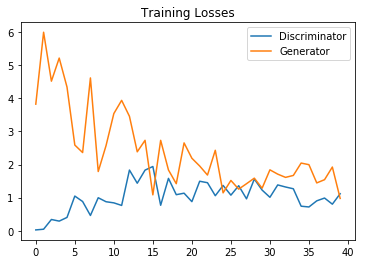

In [26]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

# Generator samples from training

In [27]:
def  view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

In [28]:

# Load samples from generator taken while training# Load  
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

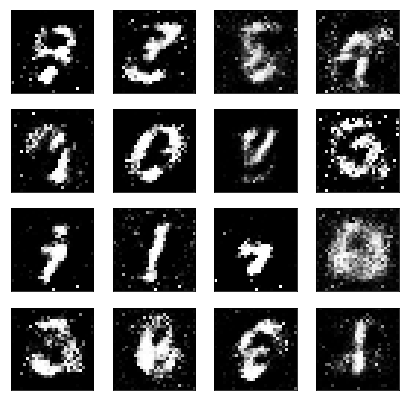

In [29]:
_ = view_samples(-1, samples)

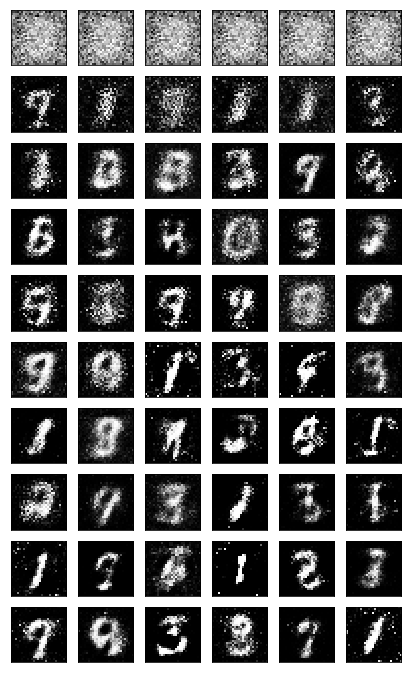

In [30]:
rows, cols = 10, 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

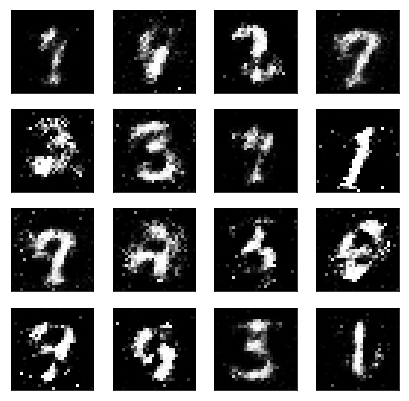

In [31]:
saver  ==  tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_z = np.random.uniform(-1, 1, size=(16, z_size))
    gen_samples = sess.run(
                   generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha),
                   feed_dict={input_z: sample_z})
_ = view_samples(0, [gen_samples])